<font size = 5 face="Arial"><b>Обнаружение падения</b></font>

<font size = 4 face="Arial"><b>Введение</b></font>

<font size = 3 face="Arial">Ссылка на kaggle: https://www.kaggle.com/datasets/jorekai/anomaly-detection-falling-people-events</font>

<font size = 3 face="Arial">Набор данных использовался во время написания диссертации для разработки безопасной среды в рамках умного дома. Целью исследования является обнаружение падения пожилых людей.<br>Параметры X, Y и Z представляют значения ускорений датчика по каждой координате. Временные метки каждого измерения были удалены, поскольку временные метки как признак, как правило, являются наиболее значимыми компонентами задач классификации.<br>010-000-024-033, 010-000-030-096, 020-000-032-221 и 020-000-033-111 представляют собой активность каждого датчика. В ходе экспериментов использовались четыре датчика, которые закреплялись на груди, лодыжках и поясе человека.<br>Метки представляют собой падение/отсутствие падения, где 0 — нормальное явление, а 1 — аномальное событие падения. </font>

<font size = 4 face="Arial"><b>1 Исследовательский анализ</b></font>

In [81]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from os import listdir
from os.path import isfile, join
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (recall_score, precision_score, PrecisionRecallDisplay, average_precision_score, 
                            precision_recall_curve, roc_auc_score)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, TomekLinks
from sklearn.model_selection import train_test_split
import joblib

<font size = 3 face="Arial">Загрузка датасета</font>

In [99]:
train_filenames = [join('data', f) for f in listdir('data') if isfile(join('data', f))]
X = pd.concat([pd.read_csv(f) for f in train_filenames], ignore_index=True)

X

,x,y,z,010-000-024-033,010-000-030-096,020-000-032-221,020-000-033-111,anomaly
0,18.495860,13.766527,14.362624,0.0,0.0,0.0,1.0,0.0
1,18.501072,13.827225,14.270268,0.0,0.0,1.0,0.0,0.0
2,18.405950,13.868976,14.094804,1.0,0.0,0.0,0.0,0.0
3,18.444572,13.910701,14.116078,0.0,1.0,0.0,0.0,0.0
4,18.418470,13.933917,14.320566,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
164254,9.538934,13.048507,12.344991,0.0,0.0,0.0,1.0,0.0
164255,9.545872,13.057525,12.363552,1.0,0.0,0.0,0.0,0.0
164256,9.575217,13.080459,12.180427,0.0,0.0,1.0,0.0,0.0
164257,9.495590,12.995833,12.142522,0.0,1.0,0.0,0.0,0.0


<font size = 3 face="Arial">Определение соотношения классов</font>

In [3]:
X['anomaly'].value_counts()

0.0    156076
1.0      8183
Name: anomaly, dtype: int64

In [4]:
X['anomaly'].value_counts(normalize=True)

0.0    0.950182
1.0    0.049818
Name: anomaly, dtype: float64

<font size = 3 face="Arial">В датасете можно наблюдать сильный дисбаланс классов</font>

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164259 entries, 0 to 164258
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   x                164259 non-null  float64
 1   y                164259 non-null  float64
 2   z                164259 non-null  float64
 3   010-000-024-033  164259 non-null  float64
 4   010-000-030-096  164259 non-null  float64
 5   020-000-032-221  164259 non-null  float64
 6   020-000-033-111  164259 non-null  float64
 7   anomaly          164259 non-null  float64
dtypes: float64(8)
memory usage: 10.0 MB


In [6]:
X.isnull().sum()

x                  0
y                  0
z                  0
010-000-024-033    0
010-000-030-096    0
020-000-032-221    0
020-000-033-111    0
anomaly            0
dtype: int64

<font size = 3 face="Arial">Проверка на дубликаты</font>

In [7]:
sum(X.duplicated())

0

In [8]:
X.describe()

,x,y,z,010-000-024-033,010-000-030-096,020-000-032-221,020-000-033-111,anomaly
count,164259.000000,164259.000000,164259.000000,164259.000000,164259.000000,164259.000000,164259.000000,164259.000000
mean,13.115340,12.428262,11.432256,0.263931,0.258220,0.260668,0.217181,0.049818
std,3.855839,2.770708,2.076351,0.440764,0.437657,0.439000,0.412328,0.217569
min,4.077736,6.042775,4.600291,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.648794,10.353295,9.955483,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.600008,11.834302,11.302346,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.379985,14.546588,13.076450,1.000000,1.000000,1.000000,0.000000,0.000000
max,24.360715,19.895179,16.902571,1.000000,1.000000,1.000000,1.000000,1.000000


<font size = 4 face="Arial"><b>1.1 Зависимоть метки класса от показателей датчиков</b></font>

<font size = 3 face="Arial">Вычисление среднего значения с датчиков по каждой координате в зависимости от метки класса</font>

In [3]:
X.groupby(by = 'anomaly')['x', 'y', 'z'].agg(['mean', 'std'])

x                    y                    z          
              mean       std       mean       std       mean       std
anomaly                                                               
0.0      13.215013  3.822201  12.506749  2.799065  11.487846  2.031956
1.0      11.214260  3.998982  10.931265  1.518624  10.371967  2.570518

<font size = 3 face="Arial">Распределение координат в зависимости от метки класса</font>

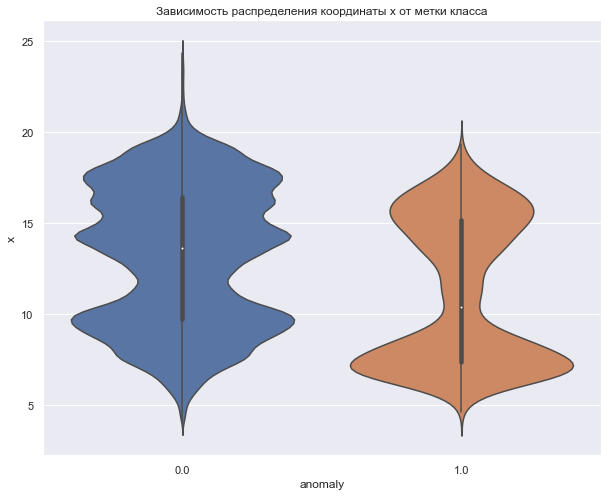

In [10]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Зависимость распределения координаты х от метки класса")
sns.violinplot(y = X['x'], scale = 'width', x = X['anomaly'])
plt.show()

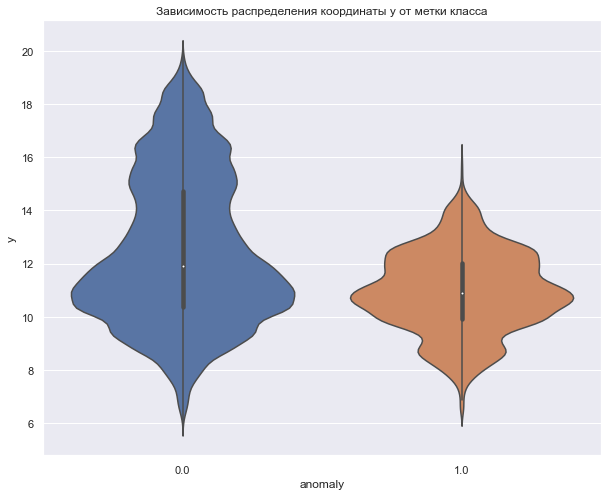

In [4]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Зависимость распределения координаты y от метки класса")
sns.violinplot(y = X['y'], scale = 'width', x = X['anomaly'])
plt.show()

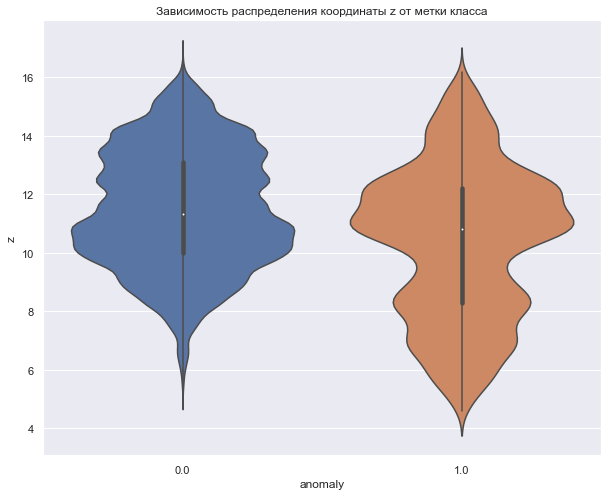

In [5]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Зависимость распределения координаты z от метки класса")
sns.violinplot(y = X['z'], scale = 'width', x = X['anomaly'])
plt.show()

<font size = 3 face="Arial">Средние значения отличаются, однако, на распределениях это малозаметно. С другой стороны, на распределениях с меткой класса 1 присутствуют ярко выраженные пики и показатели датчиков присутвуют не во всем диапазоне возможных значений(по крайней мере у координат х и у). Можно предположить, что момент падения характеризуется определенными значениями датчиков. Однако, это не отменяет наличия почти полного пересечения классов. Рассмотрим подробнее распределения.</font>

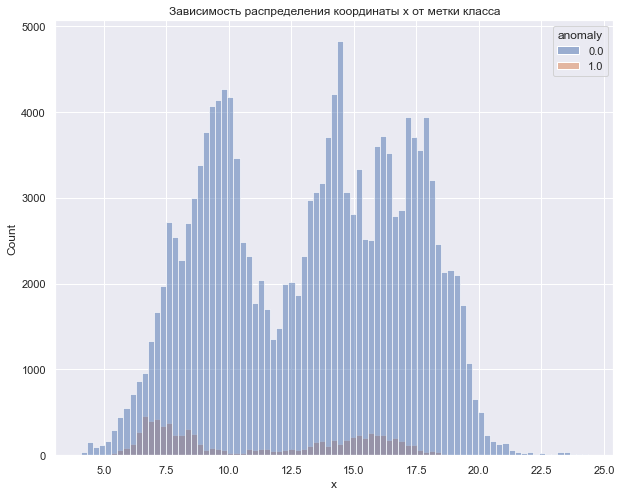

In [13]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Зависимость распределения координаты х от метки класса")
sns.histplot(data = X, x = 'x', hue = 'anomaly')
plt.show()

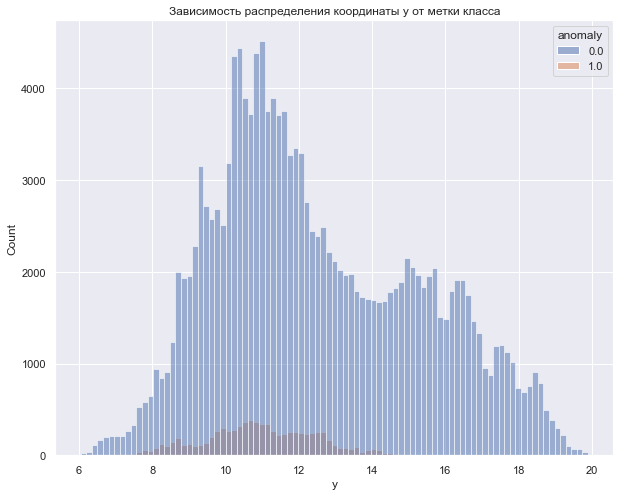

In [14]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Зависимость распределения координаты y от метки класса")
sns.histplot(data = X, x = 'y', hue = 'anomaly')
plt.show()

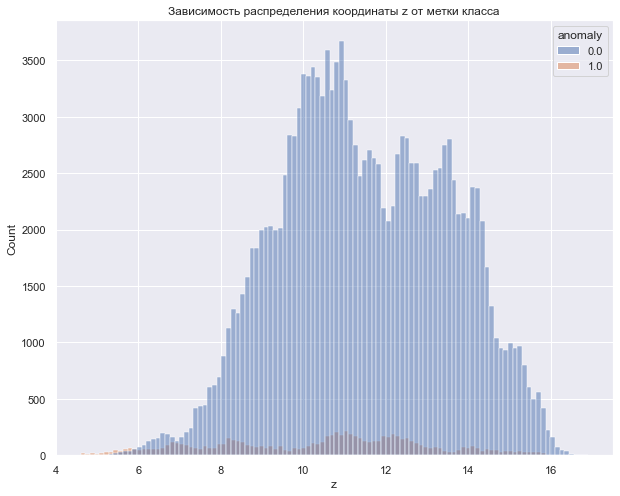

In [15]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Зависимость распределения координаты z от метки класса")
sns.histplot(data = X, x = 'z', hue = 'anomaly')
plt.show()

<font size = 3 face="Arial">По распределению видно, что при падении человека значения по координатам х и у находились в определенных диапазонах (более узком, чем при метке класса 0).<br>- х от 6 до 10 и от 12 до 18;<br>- у от 8 до 13.</font>

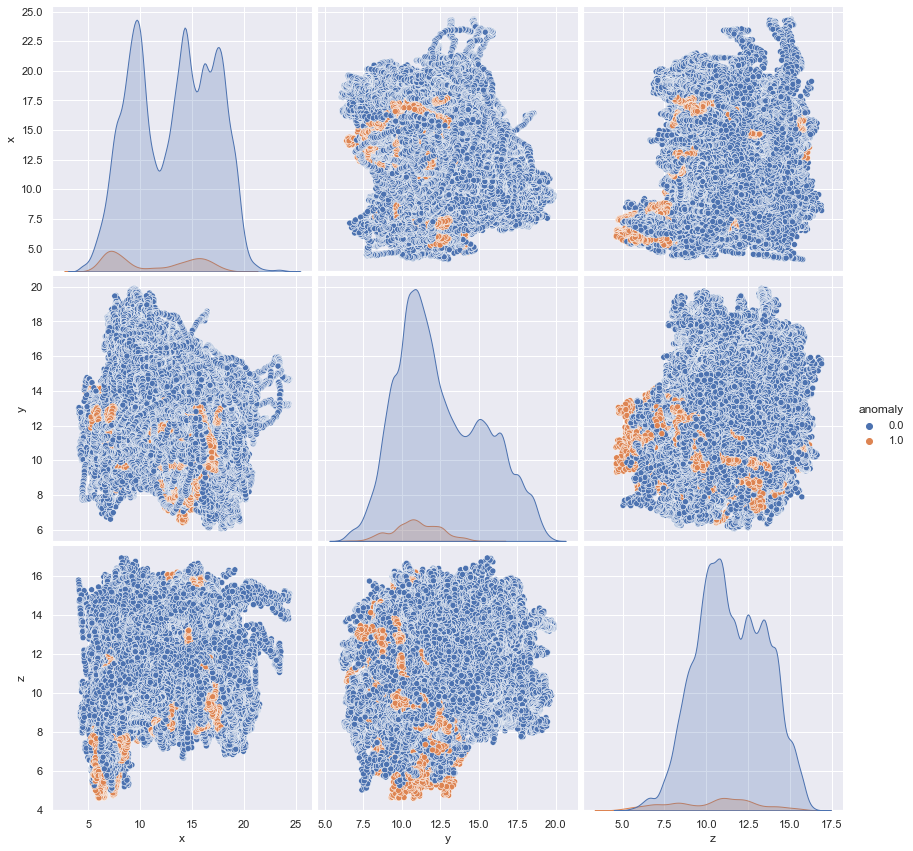

In [16]:
sns.pairplot(X[['x', 'y', 'z', 'anomaly']], hue = 'anomaly', height = 4)
plt.show()

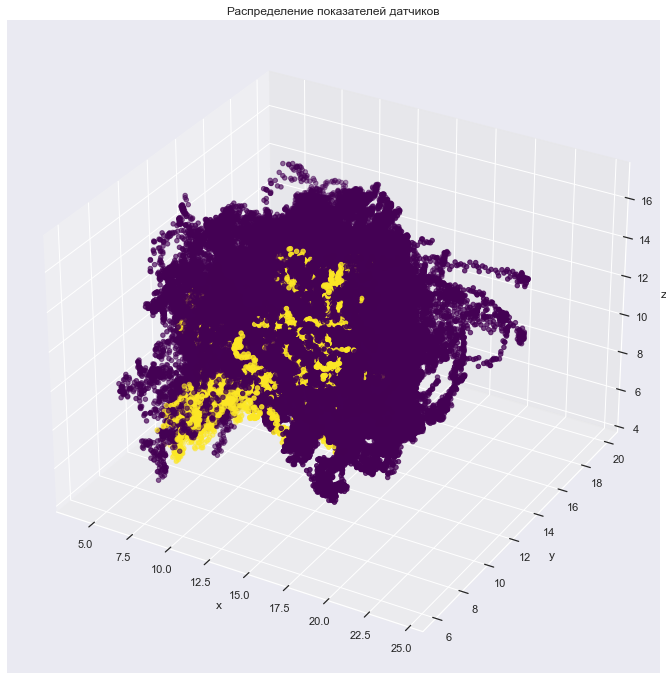

In [17]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X['x'], X['y'], X['z'], c=X['anomaly'], cmap='viridis', label =X['anomaly'])
ax.set_title("Распределение показателей датчиков")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

<font size = 3 face="Arial">Графики выше еще раз подтверждают, что значения датчиков при падении человека лежат в оганиченных областях. Можно сделать предположение, что метрические или древовидные алгоритмы покажут результат лучше, чем линейные.</font>

<font size = 4 face="Arial"><b>1.2 Зависимоть метки класса от типа датчика</b></font>

<font size = 3 face="Arial">Создадим вспомагательную колонку с названием датчика. </font>

In [8]:
X['sensor'] = X[['010-000-024-033', '010-000-030-096', '020-000-032-221', '020-000-033-111']].idxmax(axis=1)
X.head(10)

,x,y,z,010-000-024-033,010-000-030-096,020-000-032-221,020-000-033-111,anomaly,sensor
0,18.495860,13.766527,14.362624,0.0,0.0,0.0,1.0,0.0,020-000-033-111
1,18.501072,13.827225,14.270268,0.0,0.0,1.0,0.0,0.0,020-000-032-221
2,18.405950,13.868976,14.094804,1.0,0.0,0.0,0.0,0.0,010-000-024-033
3,18.444572,13.910701,14.116078,0.0,1.0,0.0,0.0,0.0,010-000-030-096
4,18.418470,13.933917,14.320566,0.0,0.0,0.0,1.0,0.0,020-000-033-111
5,18.359263,13.973045,14.140171,1.0,0.0,0.0,0.0,0.0,010-000-024-033
6,18.320574,14.057877,14.276627,0.0,0.0,0.0,1.0,0.0,020-000-033-111
7,18.385107,14.109591,14.395640,0.0,0.0,1.0,0.0,0.0,020-000-032-221
8,18.342121,14.091387,14.215412,1.0,0.0,0.0,0.0,0.0,010-000-024-033
9,18.424644,14.128410,14.240369,0.0,1.0,0.0,0.0,0.0,010-000-030-096


In [9]:
X['sensor'].value_counts(normalize = True)

010-000-024-033    0.263931
020-000-032-221    0.260668
010-000-030-096    0.258220
020-000-033-111    0.217181
Name: sensor, dtype: float64

<font size = 3 face="Arial">Количество измерений для разных датчиков имеют примерно одинаковую величину.</font>

In [10]:
X.groupby(by = ['anomaly','sensor'])['x', 'y', 'z'].agg(['mean', 'std', 'max', 'min'])

x                                         y  \
                              mean       std        max       min       mean   
anomaly sensor                                                                 
0.0     010-000-024-033  13.245342  3.795154  24.315322  4.077736  12.535476   
        010-000-030-096  13.184554  3.803445  24.305469  4.124765  12.543025   
        020-000-032-221  13.300428  3.814322  24.345720  4.172887  12.472959   
        020-000-033-111  13.111696  3.883475  24.360715  4.135656  12.469339   
1.0     010-000-024-033  11.311269  4.002809  19.269304  4.661255  11.013762   
        010-000-030-096  11.164932  3.989274  19.280939  4.785223  10.965955   
        020-000-032-221  11.307723  4.032780  19.333549  4.753906  10.899890   
        020-000-033-111  11.049078  3.962619  19.182016  4.786943  10.827756   

                                                                z            \
                              std        max       min       mean       std   
anomaly sensor                                                                
0.0     010-000-024-033  2.800532  19.887167  6.068592  11.492634  2.022354   
        010-000-030-096  2.780037  19.860791  6.042775  11.360757  2.029322   
        020-000-032-221  2.803600  19.821583  6.057368  11.556526  2.036309   
        020-000-033-111  2.813449  19.895179  6.074539  11.550269  2.034520   
1.0     010-000-024-033  1.541276  15.911535  6.435211  10.464179  2.570433   
        010-000-030-096  1.560481  15.518157  6.399819  10.209211  2.549896   
        020-000-032-221  1.499971  15.993734  6.472341  10.470544  2.586091   
        020-000-033-111  1.453499  15.584773  6.627954  10.348421  2.569006   

                                              
                               max       min  
anomaly sensor                                
0.0     010-000-024-033  16.511532  5.026213  
        010-000-030-096  16.367608  5.121533  
        020-000-032-221  16.902571  5.103257  
        020-000-033-111  16.788161  5.282236  
1.0     010-000-024-033  16.175180  4.612978  
        010-000-030-096  15.898066  4.600291  
        020-000-032-221  16.070880  4.647833  
        020-000-033-111  15.919223  4.621177

<font size = 3 face="Arial">На основе статистик выше можно сделать вывод, что распределение показателей одинаковое для каждого датчика (относительно координат и меток класса). Для наглядности построим графики.</font>

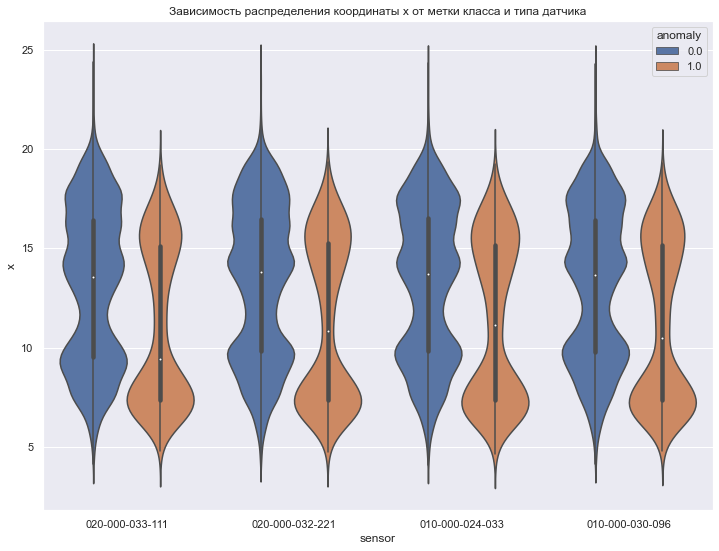

In [21]:
fig, ax = plt.subplots(figsize = (12,9))
ax.set_title("Зависимость распределения координаты х от метки класса и типа датчика")
sns.violinplot(y = X['x'], scale = 'width', x = X['sensor'], hue = X['anomaly'])
plt.show()

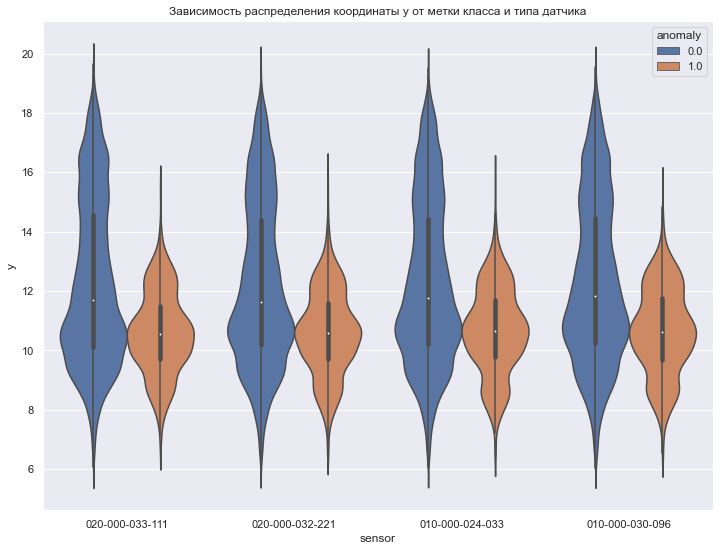

In [23]:
fig, ax = plt.subplots(figsize = (12,9))
ax.set_title("Зависимость распределения координаты y от метки класса и типа датчика")
sns.violinplot(y = X_train['y'], scale = 'width', x = X_train['sensor'], hue = X_train['anomaly'])
plt.show()

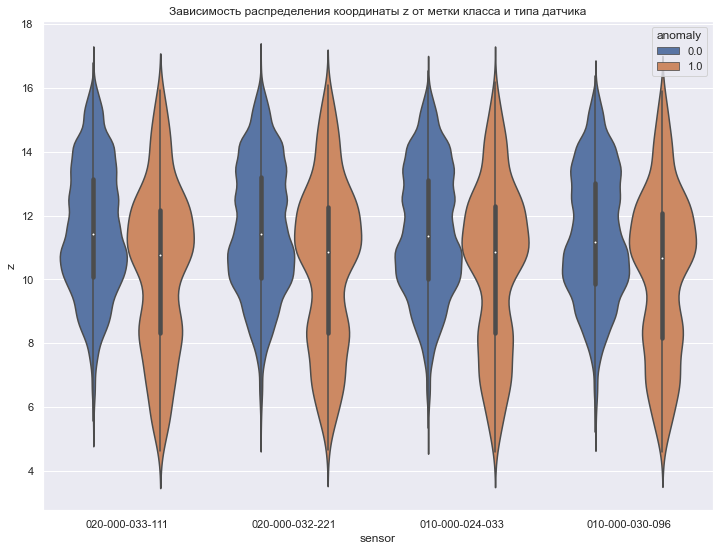

In [22]:
fig, ax = plt.subplots(figsize = (12,9))
ax.set_title("Зависимость распределения координаты z от метки класса и типа датчика")
sns.violinplot(y = X['z'], scale = 'width', x = X['sensor'], hue = X['anomaly'])
plt.show()

<font size = 3 face="Arial">Графики выше иллюстрируют, что тип датчика, действительно, не влияет на распределение показателей, а, следовательно, и на результаты классификации.</font>

In [11]:
X.drop("sensor", axis=1, inplace = True)

<font size = 4 face="Arial"><b>2 Построение модели</b></font>

<font size = 3 face="Arial">В качестве критерия качества используется PR-AUC (или же average precision). После чего лучший рузультат выбирается на основании максимального значения precision при recall = 90%. Выбранные значения метрики recall продиктованы недопустимостью отсутствия реакции на падения человека.</font>

<font size = 3 face="Arial">Разбиение на тренировочную и тестовую выборки.</font>

In [100]:
y = X['anomaly']
X.drop("anomaly", axis=1, inplace = True)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, stratify=y)

In [14]:
y_test.value_counts(normalize=True)

0.0    0.950177
1.0    0.049823
Name: anomaly, dtype: float64

In [15]:
X_train.shape

(123194, 7)

<font size = 4 face="Arial"><b>2.1 Baseline</b></font>

<font size = 3 face="Arial">В качестве базовой модели будет использована логистическая регрессия без тюнинга параметров.</font>

In [85]:
scaler = ColumnTransformer([
    ('num',StandardScaler(),slice(0, -4))], verbose_feature_names_out = False, remainder = 'passthrough')
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(), slice(0, -4, None))],
                  verbose_feature_names_out=False)

In [33]:
scaler.get_feature_names_out()

array(['x', 'y', 'z', '010-000-024-033', '010-000-030-096',
       '020-000-032-221', '020-000-033-111'], dtype=object)

In [34]:
df=pd.DataFrame(data=scaler.transform(X_train),columns=scaler.get_feature_names_out())
df

,x,y,z,010-000-024-033,010-000-030-096,020-000-032-221,020-000-033-111
0,1.178582,-0.321748,-0.451219,0.0,0.0,0.0,1.0
1,1.227275,-0.424327,-0.486409,0.0,0.0,0.0,1.0
2,-1.761671,-0.516825,-2.981228,0.0,0.0,0.0,1.0
3,1.572436,-0.645070,0.796961,0.0,0.0,1.0,0.0
4,1.223895,-0.940104,0.857154,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
123189,-1.409809,-0.174433,-0.134723,0.0,0.0,1.0,0.0
123190,2.015695,0.424881,-0.711645,0.0,1.0,0.0,0.0
123191,1.249271,-0.788554,0.941914,0.0,0.0,1.0,0.0
123192,-0.219054,1.407006,0.400247,0.0,0.0,1.0,0.0


In [17]:
baseline = LogisticRegression(class_weight = 'balanced')
baseline.fit(scaler.fit_transform(X_train), y_train)

LogisticRegression(class_weight='balanced')

In [18]:
y_pred = baseline.predict(scaler.transform(X_test))
recall_score(y_test, y_pred)

0.6715542521994134

In [19]:
precision_score(y_test, y_pred)

0.10635498103568387

<font size = 3 face="Arial">Получим вероятности классов</font>

In [20]:
y_score = baseline.predict_proba(scaler.transform(X_test))

In [21]:
average_precision_score(y_test, y_score[:,1])

0.17812333102420094

In [22]:
prec, rec, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [86]:
def p_r_plot(estimator = None, X = None, y = None, legend_name = 'default name', title = 'default title'):
    """
    Построение PR-кривой
    """
    fig, ax = plt.subplots(figsize = (12,9))
    display = PrecisionRecallDisplay.from_estimator(
        estimator, X, y, name=legend_name, ax = ax)
    display.ax_.set_title(title, fontsize = 20)
    display.ax_.yaxis.get_label().set_fontsize(15)
    display.ax_.xaxis.get_label().set_fontsize(15)
    plt.legend(loc='upper right', fontsize=15)
    plt.show()

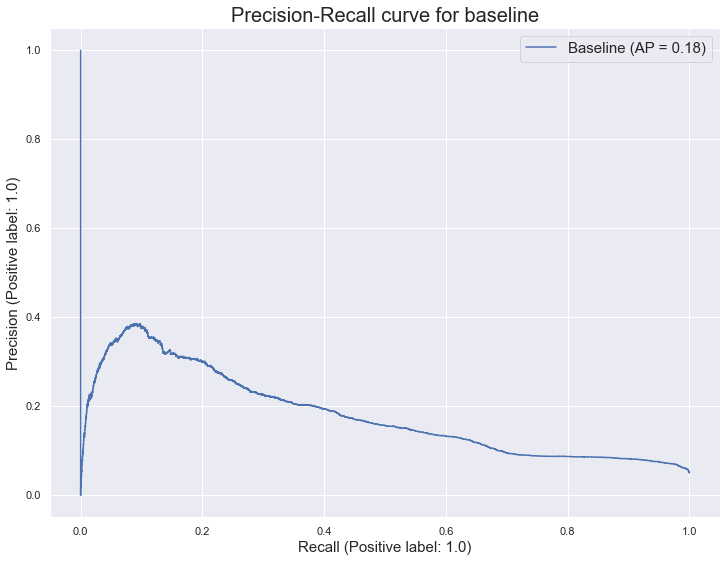

In [24]:
p_r_plot(estimator = baseline, X = scaler.transform(X_test), y = y_test, 
        legend_name = 'Baseline', title = 'Precision-Recall curve for baseline')

<font size = 3 face="Arial">Значения метрики precision, recall и порога при значнии recall>90%.</font>

In [25]:
level = np.where(rec > 0.90)[0].shape[0]-1

In [26]:
prec[level], rec[level], thresholds[level]

(0.08152246072139854, 0.9002932551319648, 0.3373605623161536)

<font size = 4 face="Arial"><b>2.2 Логистическая регрессия</b></font>

In [87]:
poly = ColumnTransformer([('poly',PolynomialFeatures(degree = 2),slice(0, -4))], remainder = 'passthrough',
                        verbose_feature_names_out = False)

In [28]:
steps_logit=[('poly',poly), ('scaler',scaler), ('logit', LogisticRegression(class_weight = 'balanced'))]
pipe_logit = Pipeline(steps=steps_logit)
 
param_grid = {'logit__C':list(np.logspace(-2, 4, 20)),
              'poly__poly__degree': [1,2,3,4,5]
             }
grid_logit = GridSearchCV(estimator = pipe_logit, param_grid = param_grid, cv = 5, scoring = 'average_precision',
                          verbose=3, n_jobs = -1)
grid_logit.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('poly',
                                                                         PolynomialFeatures(),
                                                                         slice(0, -4, None))],
                                                          verbose_feature_names_out=False)),
                                       ('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         slice(0, -4, None))],
                                                          verbose_feature_names_out=False)),
                                       ('logit',
                                        Logistic...
                                      0.18329807108324356, 0.37926901907322497,
                                      0.7847599703514611, 1.623776739188721,
                                      3.359818286283781, 6.951927961775605,
                                      14.38449888287663, 29.76351441631316,
                                      61.584821106602604, 127.42749857031322,
                                      263.6650898730355, 545.5594781168514,
                                      1128.8378916846884, 2335.7214690901214,
                                      4832.930238571752, 10000.0],
                         'poly__poly__degree': [1, 2, 3, 4, 5]},
             scoring='average_precision', verbose=3)

<font size = 3 face="Arial">Лучшая модель</font>

In [29]:
grid_logit.best_params_

{'logit__C': 1128.8378916846884, 'poly__poly__degree': 2}

In [35]:
logit_best = grid_logit.best_estimator_
y_pred = logit_best.predict(X_test)
y_score = logit_best.predict_proba(X_test)

In [31]:
average_precision_score(y_test, y_score[:,1])

0.23866947200635774

In [32]:
#y_pred = logit_best.predict(X_train)
#y_score = logit_best.predict_proba(X_train)
#average_precision_score(y_train, y_score[:,1])


0.22866852909390176

In [36]:
prec, rec, thresholds = precision_recall_curve(y_test, y_score[:,1])

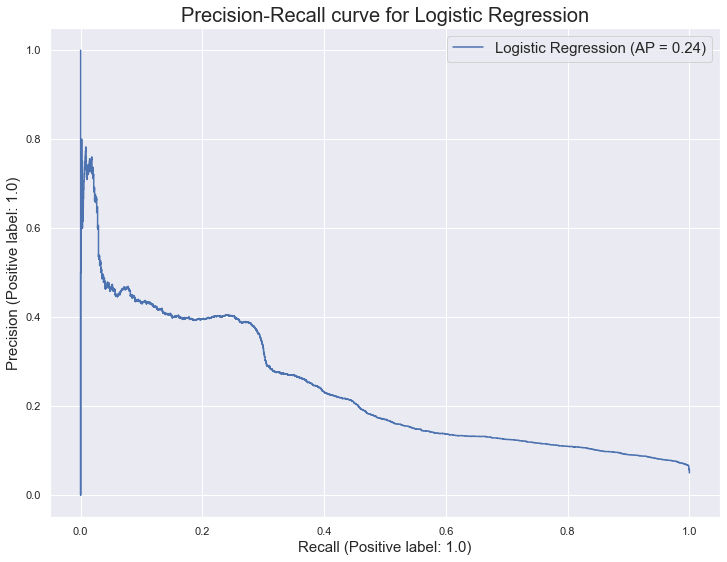

In [37]:
p_r_plot(estimator = logit_best, X = X_test, y = y_test, 
        legend_name = 'Logistic Regression', title = 'Precision-Recall curve for Logistic Regression')

<font size = 3 face="Arial">Значения метрики precision, recall и порога при значнии recall>90%.</font>

In [38]:
level = np.where(rec > 0.9)[0].shape[0]-1
prec[level], rec[level], thresholds[level]

(0.09072550854553514, 0.9002932551319648, 0.3856179360756356)

<font size = 4 face="Arial"><b>2.3 KNN</b></font>

In [49]:
steps_knn=[('scaler',scaler), ('knn', KNeighborsClassifier(p=2))]
pipe_knn = Pipeline(steps=steps_knn)
 
param_grid = {'knn__n_neighbors':list(range(1,30)),
              'knn__weights': ['uniform', 'distance']
             }
                                      
grid_knn = GridSearchCV(estimator = pipe_knn, param_grid = param_grid, cv = 5, scoring = 'average_precision',
                        verbose=3, n_jobs=-1)
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 58 candidates, totalling 290 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         slice(0, -4, None))],
                                                          verbose_feature_names_out=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29],
                         'knn__weights': ['uniform', 'distance']},
             scoring='average_precision', verbose=3)

<font size = 3 face="Arial">Лучшая модель</font>

In [50]:
grid_knn.best_params_

{'knn__n_neighbors': 11, 'knn__weights': 'distance'}

In [51]:
knn_best = grid_knn.best_estimator_
y_pred = knn_best.predict(X_test)
y_score = knn_best.predict_proba(X_test)

In [53]:
average_precision_score(y_test, y_score[:,1])

0.6243202345395558

In [54]:
prec, rec, thresholds = precision_recall_curve(y_test, y_score[:,1])

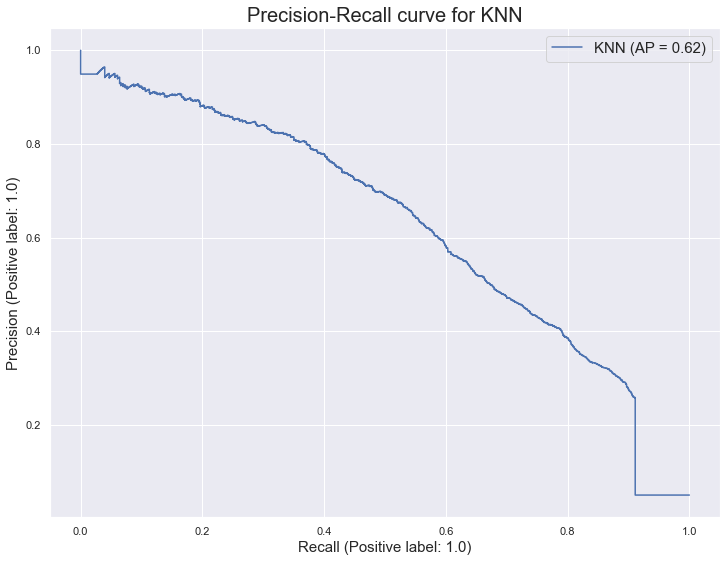

In [55]:
p_r_plot(estimator = knn_best, X = X_test, y = y_test, 
        legend_name = 'KNN', title = 'Precision-Recall curve for KNN')

<font size = 3 face="Arial">Значения метрики precision, recall и порога при значнии recall>90%.</font>

In [56]:
level = np.where(rec > 0.9)[0].shape[0]-1
prec[level], rec[level], thresholds[level]

(0.2763276327632763, 0.9002932551319648, 0.06373175557007021)

<font size = 4 face="Arial"><b>2.4 Random Forest</b></font>

In [76]:
rfc = RandomForestClassifier(class_weight='balanced')
steps_forest=[('poly',poly), ('scaler',scaler), ('rfc', rfc)]
pipe_forest = Pipeline(steps=steps_forest)
pipe_forest.get_params()

{'memory': None,
 'steps': [('poly', ColumnTransformer(remainder='passthrough',
                     transformers=[('poly', PolynomialFeatures(),
                                    slice(0, -4, None))],
                     verbose_feature_names_out=False)),
  ('scaler',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num', StandardScaler(), slice(0, -4, None))],
                     verbose_feature_names_out=False)),
  ('rfc', RandomForestClassifier(class_weight='balanced'))],
 'verbose': False,
 'poly': ColumnTransformer(remainder='passthrough',
                   transformers=[('poly', PolynomialFeatures(),
                                  slice(0, -4, None))],
                   verbose_feature_names_out=False),
 'scaler': ColumnTransformer(remainder='passthrough',
                   transformers=[('num', StandardScaler(), slice(0, -4, None))],
                   verbose_feature_names_out=False),
 'rfc': RandomForestClassifier(class_weight='bala

In [120]:
rfc = RandomForestClassifier(class_weight='balanced')
steps_forest=[('poly',poly), ('scaler',scaler), ('rfc', rfc)]
pipe_forest = Pipeline(steps=steps_forest)
param_grid = {'rfc__max_features': ['sqrt', 'log2'],
              'rfc__min_samples_leaf': [1, 3, 5, 7],
              'rfc__max_depth': [70, 75, 80, 85, 90],
              'poly__poly__degree': [1, 2, 3, 4, 5]
             }

grid_forest = GridSearchCV(estimator = pipe_forest, param_grid = param_grid, cv = 5, scoring = 'average_precision',
                        verbose=3, n_jobs=-1)
grid_forest.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('poly',
                                                                         PolynomialFeatures(),
                                                                         slice(0, -4, None))],
                                                          verbose_feature_names_out=False)),
                                       ('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         slice(0, -4, None))],
                                                          verbose_feature_names_out=False)),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'poly__poly__degree': [1, 2, 3, 4, 5],
                         'rfc__max_depth': [70, 75, 80, 85, 90],
                         'rfc__max_features': ['sqrt', 'log2'],
                         'rfc__min_samples_leaf': [1, 3, 5, 7]},
             scoring='average_precision', verbose=3)

<font size = 3 face="Arial">Лучшая модель</font>

In [121]:
grid_forest.best_params_

{'poly__poly__degree': 5,
 'rfc__max_depth': 80,
 'rfc__max_features': 'log2',
 'rfc__min_samples_leaf': 1}

In [125]:
forest_best = grid_forest.best_estimator_
y_pred = forest_best.predict(X_test)
y_score = forest_best.predict_proba(X_test)

In [126]:
average_precision_score(y_test, y_score[:,1])

0.7995865403405452

In [127]:
prec, rec, thresholds = precision_recall_curve(y_test, y_score[:,1])

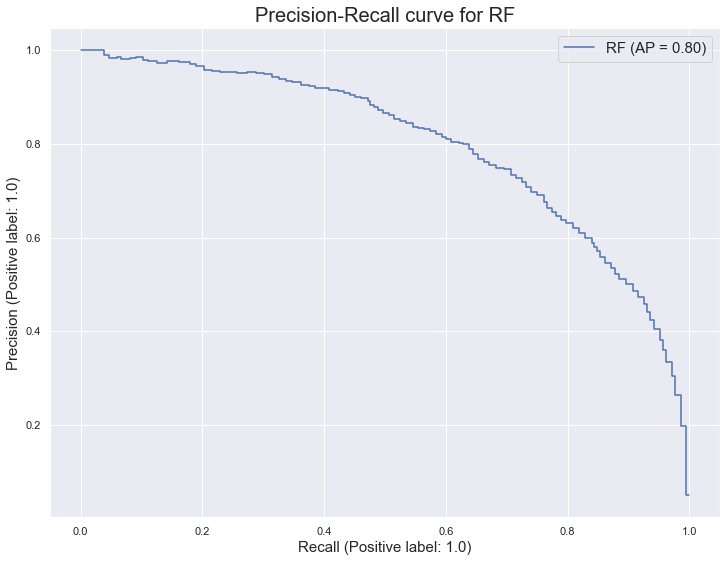

In [128]:
p_r_plot(estimator = forest_best, X = X_test, y = y_test, 
        legend_name = 'RF', title = 'Precision-Recall curve for RF')

<font size = 3 face="Arial">Значения метрики precision, recall и порога при значнии recall>90%.</font>

In [129]:
level = np.where(rec > 0.9)[0].shape[0]-1
prec[level], rec[level], thresholds[level]

(0.5004046398705152, 0.9066471163245357, 0.13)

In [119]:
#joblib.dump(forest_best, r'forest_best.pkl')

['forest_best.pkl']

<font size = 4 face="Arial"><b>2.5 XGBoost</b></font>

In [132]:
from xgboost import XGBClassifier

In [95]:
xgb = XGBClassifier(n_estimators = 1500, nthread  = 6, max_depth = 2, learning_rate=0.01, reg_lambda = 0.1)
steps_boost=[('poly',poly), ('xgb', xgb)]
pipe_boost = Pipeline(steps=steps_boost)
pipe_boost.get_params()

{'memory': None,
 'steps': [('poly', ColumnTransformer(remainder='passthrough',
                     transformers=[('poly', PolynomialFeatures(),
                                    slice(0, -4, None))],
                     verbose_feature_names_out=False)),
  ('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.01, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=2, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1500, n_jobs=None, nthread=6, num_parallel_tree

In [133]:
xgb = XGBClassifier(n_estimators = 1500, scale_pos_weight = 19)
steps_boost=[('poly',poly), ('xgb', xgb)]
pipe_boost = Pipeline(steps=steps_boost)
param_grid = {'xgb__max_depth': [2,3,4,5],
              'xgb__reg_lambda': [0.005, 0.01, 0.1, 1, 10],
              'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
              'poly__poly__degree': [1, 2, 3, 4, 5],
              'xgb__n_estimators':[500, 1000, 1500]
             }

grid_boost = GridSearchCV(estimator = pipe_boost, param_grid = param_grid, cv = 5, scoring = 'average_precision',
                        verbose=3, n_jobs=-1)
grid_boost.fit(X_train, y_train)


Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('poly',
                                                                         PolynomialFeatures(),
                                                                         slice(0, -4, None))],
                                                          verbose_feature_names_out=False)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      e...
                                                      monotone_constraints=None,
                                                      n_estimators=1500,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'poly__poly__degree': [1, 2, 3, 4, 5],
                         'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                         'xgb__max_depth': [2, 3, 4, 5],
                         'xgb__n_estimators': [500, 1000, 1500],
                         'xgb__reg_lambda': [0.005, 0.01, 0.1, 1, 10]},
             scoring='average_precision', verbose=3)

<font size = 3 face="Arial">Лучшая модель</font>

In [134]:
grid_boost.best_params_

{'poly__poly__degree': 5,
 'xgb__learning_rate': 0.2,
 'xgb__max_depth': 5,
 'xgb__n_estimators': 1500,
 'xgb__reg_lambda': 10}

In [121]:
boost_best = grid_boost.best_estimator_
y_pred = boost_best.predict(X_test)
y_score = boost_best.predict_proba(X_test)
average_precision_score(y_test, y_score[:,1])

0.7717092535788297

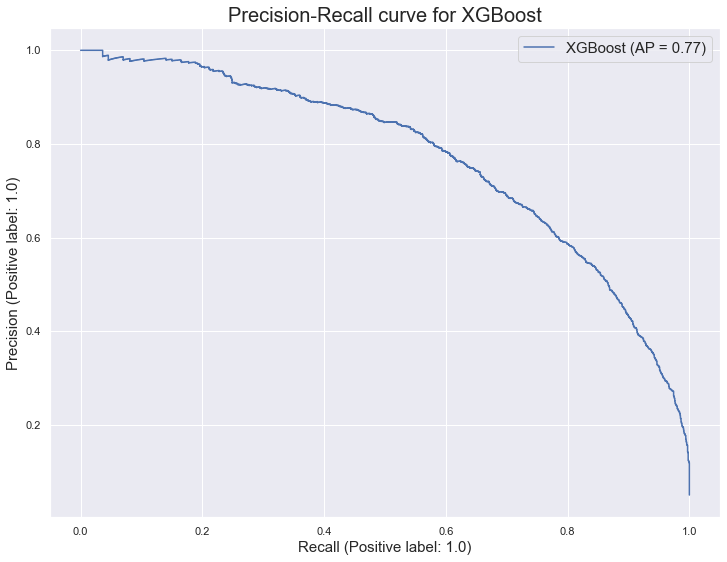

In [122]:
prec, rec, thresholds = precision_recall_curve(y_test, y_score[:,1])
p_r_plot(estimator = boost_best, X = X_test, y = y_test, 
        legend_name = 'XGBoost', title = 'Precision-Recall curve for XGBoost')

<font size = 3 face="Arial">Значения метрики precision, recall и порога при значнии recall>90%.</font>

In [123]:
level = np.where(rec > 0.9)[0].shape[0]-1
prec[level], rec[level], thresholds[level]

(0.4324958910542381, 0.9002932551319648, 0.15586053)

In [139]:
#joblib.dump(boost_best, r'boost_best.pkl')

['boost_best.pkl']

<font size = 4 face="Arial"><b>Итог</b></font>

<font size = 3 face="Arial">Модель рандомного леса показала лучший результат с показателями качества precision = 50%, recall = 90% и АР = 0,8.</font>